<a href="https://colab.research.google.com/github/Gastroam/API_RESTFUL_LOFE/blob/master/SimilarityFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastai
!pip install nbdev

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

## Siamese

In [ ]:
def label_func(fname):
    return re.match(r'^(.+)_\d+.jpg$', fname.name).groups()[0]

In [ ]:
labels = L(map(label_func, files)).unique()
len(labels)

37

In [ ]:
class SiameseImage(fastuple):
  def show(self, ctx=None, **kwargs):
    if len(self) > 2:
        img1,img2,similarity = self
    else:
        img1,img2 = self
        similarity = 'Undetermined'
    if not isinstance(img1, Tensor):
        if img2.size != img1.size: img2 = img2.resize(img1.size)
        t1,t2 = tensor(img1),tensor(img2)
        t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
    else: t1,t2 = img1,img2
    line = t1.new_zeros(t1.shape[0],t1.shape[1],10)
    return show_image(torch.cat([t1,line,t2], dim=2),title=similarity, ctx=ctx, **kwargs)

In [ ]:
class SiameseTransform(Transform):
  def __init__(self, files, splits):
    self.splbl2files = [{l:[f for f in files[splits[i]] if label_func(f)==l] for l in labels}
                        for i in range(2)]
    self.valid = {f:self._draw(f,1) for f in files[splits[1]]}
  
  def encodes(self, f):
    f2,same = self.valid.get(f, self._draw(f))
    im1,im2 = PILImage.create(f),PILImage.create(f2)
    return SiameseImage(im1,im2,int(same))

  def _draw(self, f, splits=0):
    same = random.random() <.5
    cls = label_func(f)
    if not same: cls = random.choice([l for l in labels if l != cls])
    return random.choice([f for f in self.splbl2files[splits][cls]]),same

In [ ]:
splits = RandomSplitter(seed=23)(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)
sdls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [ ]:
s = sdls.one_batch()
s[0].shape

(64, 3, 224, 224)

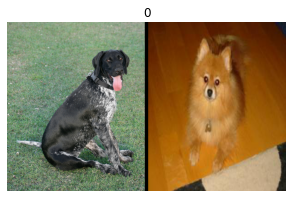

In [ ]:
show_at(tls,23);

In [ ]:
valids = [v[0] for k,v in tfm.valid.items()]
assert not [v for v in valids if v in (files[splits[0]])]

In [ ]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [ ]:
encoder = create_body(resnet34, cut=-2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
head = create_head(512*2, 1, ps=0.5)

In [ ]:
smodel = SiameseModel(encoder, head)

In [ ]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [ ]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [ ]:
slearn = Learner(sdls, smodel, loss_func=loss_func, 
                splitter=siamese_splitter, metrics=accuracy)

In [ ]:
slearn.freeze()

In [ ]:
slearn.fit_one_cycle(2, 3e-3)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

In [ ]:
slearn.unfreeze()
slearn.fit_one_cycle(4, slice(1e-6,1e-4))

In [ ]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs):
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][torch.argmax(y[2][i]).item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

In [ ]:
slearn.show_results()

## Classifier

In [ ]:
cdls = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items = get_image_files,
                 get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 splitter = RandomSplitter(),
                 item_tfms = Resize(224),
                 batch_tfms = aug_transforms()).dataloaders(path/'images')

In [ ]:
clearn = cnn_learner(cdls, resnet18, metrics = accuracy, loss_func = LabelSmoothingCrossEntropy()).to_fp16()

In [ ]:
clearn.fine_tune(5, slice(1e-5,1e-3))

In [ ]:
clearn.recorder.plot_loss()

In [ ]:
clearn.to_fp32()

## Inference

In [ ]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    return self.predict(item, rm_type_tfms=None, with_input=False)

In [ ]:
def label_func(fname):
    return re.match(r'^(.+)_\d+.jpg$', fname.name).groups()[0]

In [ ]:
def show_cam(t, cam_map, ctx):
  show_image(t, ctx=ctx)
  ctx.imshow(cam_map[0].detach().cpu(), extent=[0,t.shape[2],t.shape[1],0], 
                 alpha=.7, interpolation='BILINEAR', cmap='magma')

In [ ]:
def to_tensor(fn, dls):
  t = first(cdls.test_dl([fn]))[0]
  return dls.decode((t,))[0][0]

In [ ]:
def predict_class(fn,learn):
  im = first(learn.dls.test_dl([fn,]))[0].cpu()
  with torch.no_grad(): output = learn.model.eval().cpu()(im)
  return learn.dls.vocab[output.argmax()]

In [ ]:
class Hook():
  def __init__(self, m):
    self.hook = m.register_forward_hook(self.hook_func)
    self.stored = []
  def hook_func(self,m,i,o): self.stored.append(o.detach().cpu())
  def reset(self): self.stored = []
  def __enter__(self,*args,**kwargs): return self
  def __exit__(self,*args,**kwargs):  self.hook.remove()

In [ ]:
class SimilarityFinder():
    def __init__(self, classifier_learner, siamese_learner, files):
    def predict(self, fn, compare_n=15):
    def similar_cams(self):

In [ ]:
class SimilarityFinder:
  def __init__(self, classifier_learner, siamese_learner, files):
    self.clearn,self.slearn = classifier_learner,siamese_learner
    labels = L(map(label_func, files)).unique()
    self.lbl2files = {l:[f for f in files if label_func(f)==l] 
                      for l in labels}

  def predict(self, fn, compare_n=15):
    self.preds,self.acts,self.images,self.fns = [],[],[],[]
    cls = predict_class(fn,self.clearn)
    compare_fns = self.lbl2files[cls][:compare_n]
    hook_layer = self.slearn.model.encoder
    with Hook(hook_layer) as hook:
      for f2 in compare_fns:
          im1,im2 = PILImage.create(fn),PILImage.create(f2)
          ims = SiameseImage(im1,im2)        
          output = slearn.siampredict(ims)[0]
          self.preds.append(torch.sigmoid(output))
          self.fns.append((fn,f2))
          self.images.append((im1,im2))
          self.acts.append(hook.stored)
          hook.reset()
    self.idx = np.array(self.preds).argmax()
    sim_ims = self.images[self.idx]
    title = f'{self.preds[self.idx].item()*100:.2f}% Similarity'
    SiameseImage(sim_ims[0], sim_ims[1], title).show()
    return self.fns[self.idx][1]
    
  def similar_cams(self):
    sweight = self.slearn.model.head[-1].weight.cpu()
    act1,act2 = self.acts[self.idx]
    cam_map1 = torch.einsum('ik,kjl->ijl', sweight, act1[0])
    cam_map2 = torch.einsum('ik,kjl->ijl', sweight, act2[0])
    f1,f2 = self.fns[self.idx]
    t1,t2 = to_tensor(f1,slearn.dls),to_tensor(f2,slearn.dls)
    _,axs = plt.subplots(ncols=2)
    show_cam(t1,cam_map1,axs[0])
    show_cam(t2,cam_map2,axs[1])

In [ ]:
simfinder = SimilarityFinder(clearn,slearn,files)

Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_77.jpg')

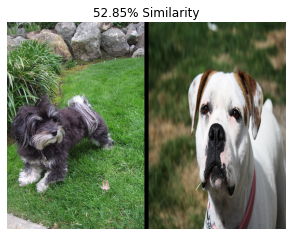

In [ ]:
simfinder.predict(files[204], 3)

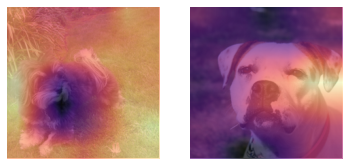

In [ ]:
simfinder.similar_cams()

#Medium Article

Image: 

`im` -> classify (lbl) ^compare -> `im``im` interpret

**Diving into the Implementation**

Let’s begin where we can get a clear view of the whole project: at the end. 

The `SimilarityFinder` class is my modularized version of the inference pipeline, and once we understand its three methods, we will have grokked the essence of the project. `SimilarityFinder` strings together two models, a classifier that predicts the breed of a pet and a comparison (`Siamese`) model that determines whether two images are 'similar'. We use them to predict the image in our comparison image files that is most similar to the input image.

``` python
class SimilarityFinder:
    def __init__(self, classifier_learner, siamese_learner, files):
    def predict(self, fn, compare_n=15):
    def similar_cams(self):
```

In `__init__` we preprocess the image files that we are using for comparison into `lbl2files`, a useful mapping for `predict`, and initialize our two `Learner`s. A `Learner` is a fastai class that wraps the model, data, and a few other training components into a single class, so we can think of them as the two parts of our pipeline. 

```python
def label_func(fname):
    """extracts the pet breed from a file name"""
    return re.match(r'^(.+)_\d+.jpg$', fname.name).groups()[0]

class SimilarityFinder:
    def __init__(self, classifier_learner, siamese_learner, files):
      self.clearn,self.slearn = classifier_learner,siamese_learner
      labels = L(map(label_func, files)).unique()
      self.lbl2files = {l:[f for f in files if label_func(f)==l] 
                        for l in labels}
```

The classifier `Learner` will serve as a heuristic for reducing the amount of images we have to sift through in predicting similarity. The Siamese `Learner` predicts similarity between two images. Together, they will allow us to find the most similar image in a sizeable dataset.

Let's continue by looking at how we built those two `Learner`s.


*Classification*

We predict the pet breed from images of pets. This is a standard classification problem, so it should seem trivial to those familiar with CNNs. There are three basic steps:
1. Extract the image files from a directory. The PETS dataset is available by default in the fastai library, so we use `untar_data` to access it.
```
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")
```

2. Preprocess the image files and store them in `DataLoaders` with fastai's Data Block API.
```
cdls = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name',
                splitter = RandomSplitter(),
                item_tfms = Resize(224),
                batch_tfms = aug_transforms()).dataloaders(path/'images')
```
3. Wrap everything in a fastai `Learner` and train the model. I used a couple tricks for training (label smoothing, mixed-precision training) in the project, but I omit them here for simplicity. They are available in the original notebook.
```
clearn = cnn_learner(cdls, resnet34, metrics=accuracy)
clearn.fit_one_cycle(n_epochs, lr)
```

The classification pipeline is complete; let's move on to the more complicated comparison pipeline.


*Comparison*

We trained a model to predict pet breed. Now, we train use a model that predicts whether two images are of the same breed. It will require defining some custom data types and a custom model, as it is not a standard application. The following implementation is drawn from the Siamese tutorial on the fastai documentation, but I made modicications on the model and training process.

Implementing the Siamese model is very similar to implementing the classifier; however, there are two key modifications. 

We input two images into the model instead of one. This means that, firstly, we need to represent our `DataLoaders` with three elements per example--first image, second image, and whether they are similar--and, secondly, we pass each image individually through the same body and concatenate the outputs of the body in the head. 

1. Exactly as before, retrieve the image files.
```python
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")
```
2. Preprocess the data with fastai's mid-level API. We create a `Transform` that opens files, pairs them with others, and outputs it as a `SiameseImage`, which is essentially a container used to display the data. Then, we apply the necessary transforms on all files with `TfmdLists` and `dataloaders`. 
```python
class SiameseTransform(Transform):
      def __init__(self, files, splits):
      """setup files into train and valid sets"""
      def encodes(self, f):
      """applies transforms on f and pairs it with another image"""
        f2,same = self.valid.get(f, self._draw(f))
        im1,im2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(im1,im2,int(same))
      def _draw(self, f, splits=0):
      """retrieve a file--same class as f with probability 0.5"""
splits = RandomSplitter(seed=23)(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)
sdls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])
```

3. Build the Model. We pass each image in the pair through the body (aka encoder), concatenate the outputs, and pass them through the head to get the prediction. Note that there is only one encoder for both images, not two encoders for each image. Then, we download some pretrained weights and assemble them together into a model.
```python
class SiameseModel(Module):
      def __init__(self, encoder, head):
          self.encoder,self.head = encoder,head
      def forward(self, x1, x2):
          ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
          return self.head(ftrs)
encoder = create_body(resnet34, cut=-2)
head = create_head(512*2, 1, ps=0.5)
smodel = SiameseModel(encoder, head)
```
4. Create the `Learner` and train the model. We deal with little wrinkles in `Learner`: specify the location of the body and head with `siamese_splitter` and cast the target as a float in `loss_func`. Note that after we customized the data and model, everything else falls into place, and we can proceed training in the standard way.
```
slearn = Learner(sdls, smodel, loss_func=loss_func, 
                splitter=siamese_splitter, metrics=accuracy)
slearn.fit_one_cycle(n_epochs, lr)
```

We use the capability of determining shared breed as a heuristic for image similarity. I use the probability that the two pets are of the same breed is the proxy for similarity: if the model is 95% confident that two pets are of the same breed, they are taken to be more similar than if the model predicts with 80% confidence.

Now, let's return to the heart of the project, where we string these capabilities together.